NaN values successfully handled.
AUC-ROC: 0.7322
Precision-Recall AUC: 0.2086
Best Threshold: -0.7261
Best F1 Score: 0.3038

Classification Report (Optimized Predictions):
                     precision    recall  f1-score   support

   Class 0 (Normal)       0.93      0.86      0.89       269
Class 1 (Anomalies)       0.24      0.41      0.30        29

           accuracy                           0.82       298
          macro avg       0.59      0.64      0.60       298
       weighted avg       0.86      0.82      0.84       298



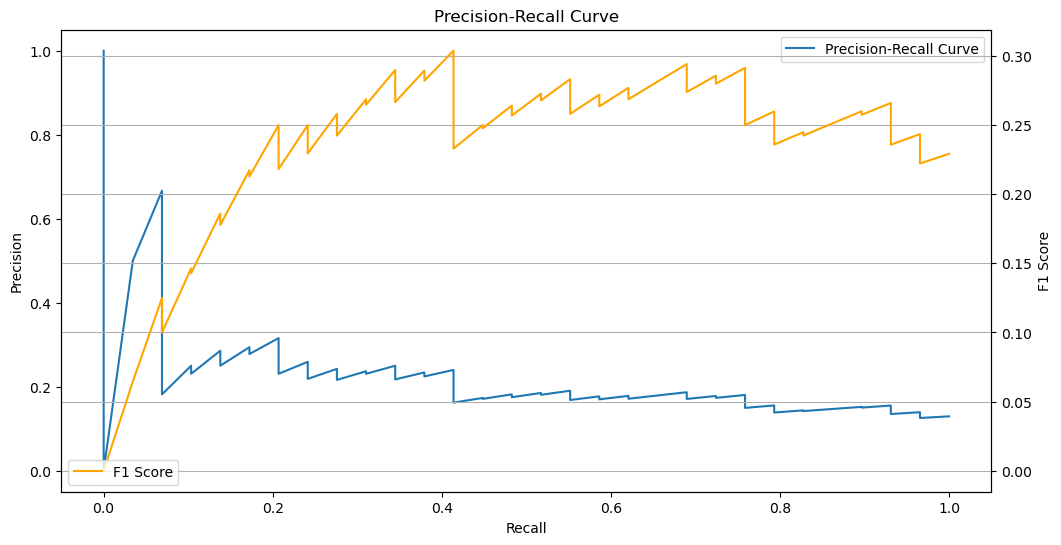

In [21]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

data = pd.read_csv("merged.csv")
# Preprocessing
X = data.iloc[:, 1:].values  # Features (replace with your dataset)
y = data.iloc[:, 0].values   # Labels (replace with your dataset)

# Handle NaN values with imputation
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
X = imputer.fit_transform(X)

# Check again for NaN values
if np.isnan(X).any():
    print("There are still NaN values!")
else:
    print("NaN values successfully handled.")
    
    
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and evaluation sets (80/20 split)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')  # Adjust nu and gamma as needed
oc_svm.fit(X_train)

# Step 3: Generate anomaly scores and predictions
scores = -oc_svm.decision_function(X_eval)  # Higher scores indicate anomalies
default_predictions = oc_svm.predict(X_eval)  # 1 for inliers, -1 for outliers
binary_predictions = np.where(default_predictions == -1, 1, 0)  # Map to 1 (anomalies) and 0 (normal)

# Step 4: Evaluate using AUC-ROC
auc_roc = roc_auc_score(y_eval, scores)
print(f"AUC-ROC: {auc_roc:.4f}")

# Step 5: Precision-Recall Curve and AUC
precision, recall, thresholds = precision_recall_curve(y_eval, scores)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Step 6: Best Threshold and F1 Score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Avoid division by zero
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Best F1 Score: {f1_scores[best_threshold_idx]:.4f}")

# Step 7: Generate binary predictions using the best threshold
optimized_predictions = (scores >= best_threshold).astype(int)

# Classification Report
print("\nClassification Report (Optimized Predictions):")
print(classification_report(y_eval, optimized_predictions, target_names=["Class 0 (Normal)", "Class 1 (Anomalies)"]))

# Step 8: Visualization
plt.figure(figsize=(12, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

plt.twinx()
plt.plot(recall, f1_scores, label="F1 Score", color="orange")
plt.ylabel("F1 Score")
plt.legend(loc="lower left")

plt.grid()
plt.show()

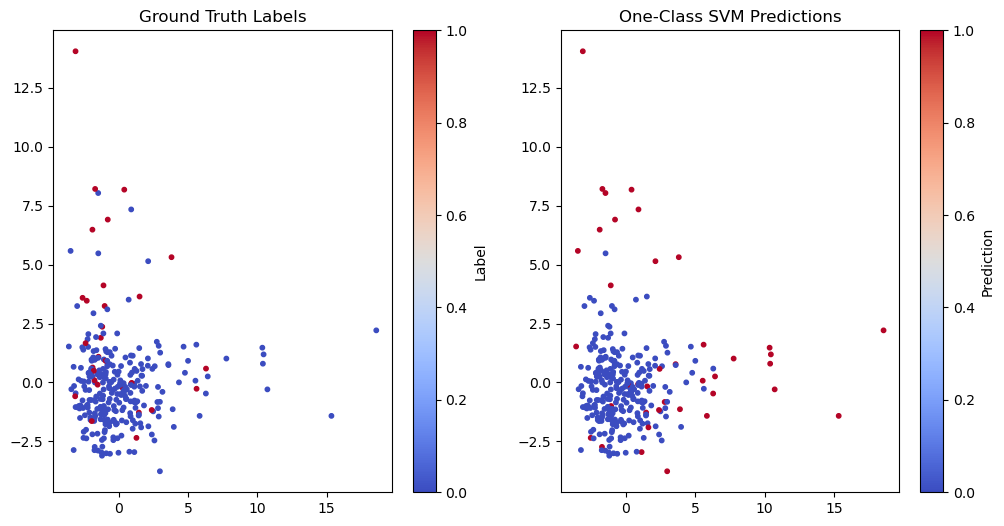

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_eval)

# Plot ground truth
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_eval, cmap='coolwarm', s=10)
plt.title("Ground Truth Labels")
plt.colorbar(label="Label")

# Plot One-Class SVM results
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=binary_predictions, cmap='coolwarm', s=10)
plt.title("One-Class SVM Predictions")
plt.colorbar(label="Prediction")
plt.show()


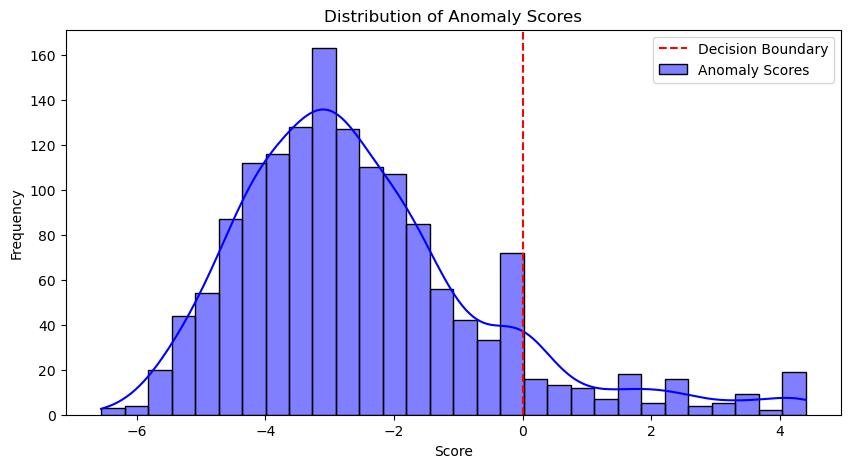

In [16]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(scores, kde=True, bins=30, color='blue', label="Anomaly Scores")
plt.axvline(x=0, color='red', linestyle='--', label="Decision Boundary")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()
